This notebook contains a brief attempt at using regression models to predict prescription drug review ratings given the text of the review. The best performing of these models has its output binned and displayed in the form of confusion matrices so that its predictions can be usefully compared with those of classifiers attempting to do the same thing.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# This commented out stuff is how you'd get pickled data from the scraper directly, but we're just using a csv file

#import pickle
#from drugSite_scrapers3 import drug, review as drug, review
#with open('ddc_depression_drugs.p', 'rb') as f:
#    data = pickle.load(f)

#print(data[0].reviews[0].condition)
#data_dicts = []
#for drug in data:
#    drug_dicts = [vars(i) for i in drug.reviews]
#    data_dicts.extend(drug_dicts)
#data_dict = [vars(i) for i in data[0].reviews]

#df = pd.DataFrame(data_dicts)
#df = df[['comment', 'condition', 'drugName', 'genRating', 'medDuration', 'reviewDate', 'upVotes']]

In [3]:
df = pd.read_csv('./data/ddc_depression_drug_reviews.csv')
df = df[pd.notnull(df['genRating'])] #Remove reviews without a corresponding rating

In [4]:
df

,comment,condition,drugName,genRating,medDuration,reviewDate,upVotes
0,"""I was taking Cymbalta for 2 1/2 months (along...",depression,Cymbalta,1.0,"[1, 6]","November 8, 2017",2
1,"""These capsules enhanced made me feel worse. ...",depression,Cymbalta,1.0,"[24, 60]","November 2, 2017",3
2,"""Took cymbalta for depression for about 6 mont...",depression,Cymbalta,1.0,NaN,"October 13, 2017",10
3,"""I took my first dose of generic Cymbalta last...",depression,Cymbalta,1.0,"[0, 1]","September 16, 2017",11
4,"""I was put on this for a while. It made me ve...",depression,Cymbalta,2.0,NaN,"August 18, 2017",22
5,"""I've been taking Cymbalta for depression for ...",depression,Cymbalta,5.0,"[24, 60]","August 10, 2017",24
7,"""Ok so I'm a 19y/o female and, After a month a...",depression,Cymbalta,6.0,"[1, 6]","June 30, 2017",14
8,"""Had panic attacks and major depression. This ...",depression,Cymbalta,10.0,NaN,"June 28, 2017",36
9,"""Just took it at its smallest available dose t...",depression,Cymbalta,10.0,"[0, 1]","June 23, 2017",58
10,"""This drug has changed my life. Before taking ...",depression,Cymbalta,9.0,"[6, 12]","June 21, 2017",42


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, f1_score

In [6]:
comments = df['comment'].tolist()
ratings = df['genRating'].tolist()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(comments, ratings, test_size=0.25, random_state=0)

In [8]:
# vocabulary and document set for the purposes of tfidf vectorizing will be based on the whole corpus,
# since this is convenient and we won't run into unseen terms. 

tfidf_vec = TfidfVectorizer(sublinear_tf=True, stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
tfidf_vec.fit(comments)
X_train_tfidf = tfidf_vec.transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [23]:
# Here we try out a few models to see what will work and what won't. 

models = []
models.append(('RBF SVR', SVR(kernel='rbf', C=1e3, gamma=0.1)))
models.append(('Lasso', Lasso(alpha=1.0)))
models.append(('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.7)))
models.append(('Linear SVR', SVR(kernel='linear', C=1e3, gamma=0.1)))
models.append(('Ridge', Ridge(alpha=0.5)))

In [10]:
trained_models = []
for name, model in models:
    trained_model = model.fit(X_train_tfidf, y_train)
    trained_models.append((name, trained_model))

In [11]:
results = []
for name, model in trained_models:
    y_pred = model.predict(X_test_tfidf)
    mae = mean_absolute_error(y_test, y_pred)
    print('{} model: mean absolute error:  {}'.format(name, mae))
    results.append((name, y_pred, y_test))

RBF SVR model: mean absolute error:  1.0222676618293942
Lasso model: mean absolute error:  2.561265937150436
ElasticNet model: mean absolute error:  2.561265937150436
Linear SVR model: mean absolute error:  1.1248410826215172
Ridge model: mean absolute error:  1.2915000511702344


In [12]:
# Let's have a look at what kind of predictions we're getting.

preds_df = pd.DataFrame(
    {
        'predicted (rbf)': results[0][1],
        'predicted (lasso)': results[1][1],
        'predicted (enet)': results[2][1],
        'predicted (linear)': results[3][1],
        'predicted (ridge)': results[4][1],
        'actual': results[0][2]
    })
preds_df

,actual,predicted (enet),predicted (lasso),predicted (linear),predicted (rbf),predicted (ridge)
0,8.0,6.984589,6.984589,5.534480,5.961095,6.194552
1,10.0,6.984589,6.984589,10.225520,8.441597,8.340883
2,1.0,6.984589,6.984589,1.100435,1.100466,2.858854
3,7.0,6.984589,6.984589,6.899684,6.900133,6.554519
4,10.0,6.984589,6.984589,8.002247,6.994110,7.098999
5,9.0,6.984589,6.984589,8.058030,5.404951,5.627750
6,8.0,6.984589,6.984589,8.128880,8.114022,7.873313
7,1.0,6.984589,6.984589,6.723615,4.023172,4.304301
8,7.0,6.984589,6.984589,6.294751,7.684854,7.596723
9,2.0,6.984589,6.984589,2.099744,2.100014,3.665339


SVR with the RBF kernel produced the best results; so now we'll bin its results in order to compare its performance to the other classification models. Confusion matrices (with results binned to five classes (1-2,3-4,5-6,7-8, and 9-10 on the rating scale)) are available in other notebooks in this project.

ElasticNet and Lasso regression techniques appear to be simply predicting the intercept; might this be because they work better when few features are important, as is shown on [this flowchart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)?

In [13]:
def bin_1_to_10(results):
    binned_results = []
    for result in results:
        binned = round(result)
        if binned > 10.0:
            binned = 10.0
        elif binned < 1.0:
            binned = 1.0
        binned_results.append(binned)
    return binned_results

def bin_1_to_5(results):
    binned_results = []
    for result in results:
        binned = round(result)
        if binned >= 9.0:
            binned = 5.0
        elif binned >= 7.0:
            binned = 4.0
        elif binned >= 5.0:
            binned = 3.0
        elif binned >= 3.0:
            binned = 2.0
        else: 
            binned = 1.0
        binned_results.append(binned)
    return binned_results

In [14]:
binned_predictions = bin_1_to_10(results[0][1])
actual_values = results[0][2]
binned_predictions[:10]

[6.0, 8.0, 1.0, 7.0, 7.0, 5.0, 8.0, 4.0, 8.0, 2.0]

In [24]:
cnf_matrix = confusion_matrix(actual_values, binned_predictions)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import itertools

%matplotlib inline

def plot_confusion_matrix(fig, ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, x_label='Predicted label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)#, rotation=45)
    ax.set_yticks(tick_marks, classes)
    
    plt.colorbar(im1,fraction=0.046, pad=0.04)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel(x_label)

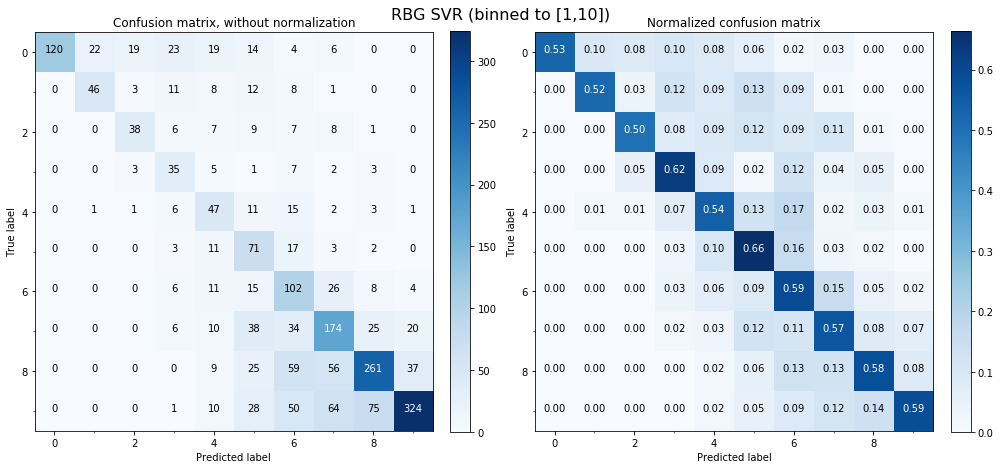

In [17]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
figSize = (14, 7)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
st = fig.suptitle('RBG SVR (binned to [1,10])', fontsize=16)
st.set_y(0.95)

ax1 = plt.subplot(gs[0])
plot_confusion_matrix(fig, ax1, cnf_matrix, classes=range(1,11),
                      title='Confusion matrix, without normalization')

ax2 = plt.subplot(gs[1])
plot_confusion_matrix(fig, ax2, cnf_matrix, classes=range(1,11), normalize=True,
                      title='Normalized confusion matrix')
fig.tight_layout()

In [18]:
binned_1_5_predictions = bin_1_to_5(binned_predictions)
binned_1_5_actual_values = bin_1_to_5(actual_values)
cnf_matrix_1_5 = confusion_matrix(binned_1_5_actual_values, binned_1_5_predictions)
accuracy_1_5 = accuracy_score(binned_1_5_actual_values, binned_1_5_predictions)
f1_1_5 = f1_score(binned_1_5_actual_values, binned_1_5_predictions, average=None)

In [19]:
cnf_matrix_1_5

array([[188,  56,  53,  19,   0],
       [  0,  82,  22,  24,   4],
       [  1,  10, 140,  37,   6],
       [  0,  12,  74, 336,  57],
       [  0,   1,  72, 229, 697]])

In [20]:
accuracy_1_5

0.68066037735849061

In [21]:
f1_1_5

array([ 0.74,  0.56,  0.5 ,  0.6 ,  0.79])

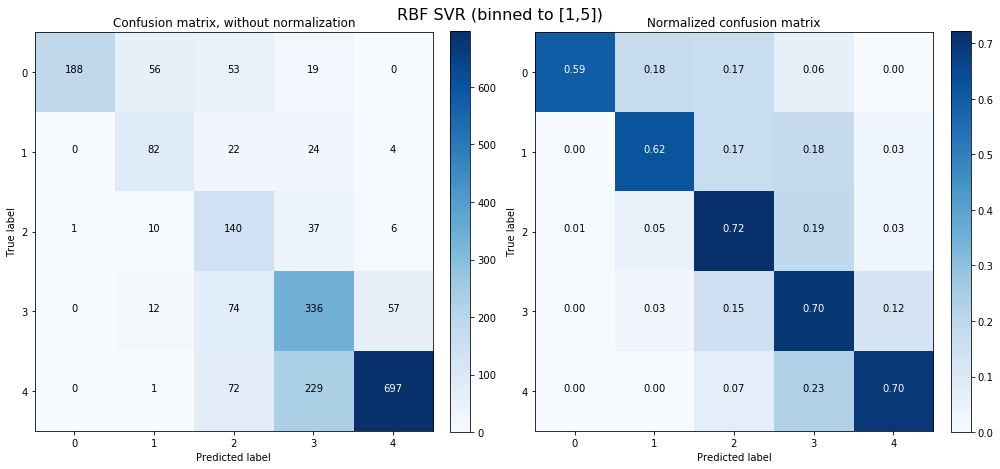

In [22]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
figSize = (14, 7)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
st = fig.suptitle('RBF SVR (binned to [1,5])', fontsize=16)
st.set_y(0.95)

ax1 = plt.subplot(gs[0])
plot_confusion_matrix(fig, ax1, cnf_matrix_1_5, classes=range(1,6),
                      title='Confusion matrix, without normalization')

ax2 = plt.subplot(gs[1])
plot_confusion_matrix(fig, ax2, cnf_matrix_1_5, classes=range(1,6), normalize=True,
                      title='Normalized confusion matrix')
fig.tight_layout()